# Training a Pytorch Model on MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
args = {
    "batch_size": 64,
    "test_batch_size": 100,
    "epochs":10,
    "lr":0.01,
    "momentum":0.5,
    "no_cuda":True,
    "seed":1,
    "log_interval":1000,
    "save_model":False
}

In [4]:
use_cuda = not args["no_cuda"] and torch.cuda.is_available()
torch.manual_seed(args["seed"])
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data/', 
        train=True, 
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.,), (1.,))])
    ),
    batch_size=args["batch_size"], 
    shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        'data/', 
        train=False, 
        transform=transforms.Compose(
            [transforms.ToTensor(),transforms.Normalize((0.,), (1.,))])
    ),
    batch_size=args["test_batch_size"], 
    shuffle=True, **kwargs)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"])

In [5]:
images, labels = iter(train_loader).next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


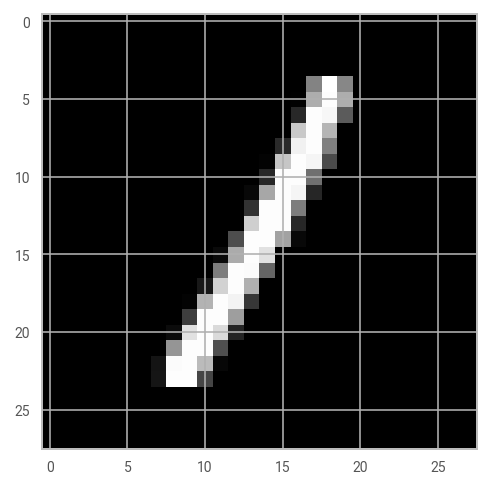

In [6]:
plt.imshow(images[0].numpy().squeeze(),cmap='gray')

In [7]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [8]:
for epoch in range(1, args["epochs"] + 1):
    train(args, model, device, train_loader, optimizer, epoch)

test(args, model, device, test_loader)

Train Epoch: 1 Loss: 2.297917
Train Epoch: 2 Loss: 0.175589
Train Epoch: 3 Loss: 0.037796
Train Epoch: 4 Loss: 0.113032
Train Epoch: 5 Loss: 0.090516
Train Epoch: 6 Loss: 0.026806
Train Epoch: 7 Loss: 0.069362
Train Epoch: 8 Loss: 0.019517
Train Epoch: 9 Loss: 0.015398
Train Epoch: 10 Loss: 0.015253

Test set: Average loss: 0.0349, Accuracy: 9887/10000 (99%)



In [9]:
torch.save(model.state_dict(), "models/torch_model.pkl")

In [10]:
from PIL import Image, ImageOps, ImageFilter
import numpy as np

im = Image.open('test_6.png')
im_blur = im.filter(ImageFilter.GaussianBlur(5))
im_small = im_blur.resize((28,28),Image.ANTIALIAS)
im_bitmap = im_small.convert("L")
im_array = np.asarray(im_bitmap)
im_float = im_array.astype('float32')
im_normalised = (im_float/256)
im_tensor = torch.tensor(im_normalised)
im_tensor_shaped = im_tensor.reshape(1,1,28,28)
with torch.no_grad():
    logps = model(im_tensor_shaped)
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
predict_val = probab.index(max(probab))
print("Predicted value: {}".format(predict_val))

Predicted value: 6


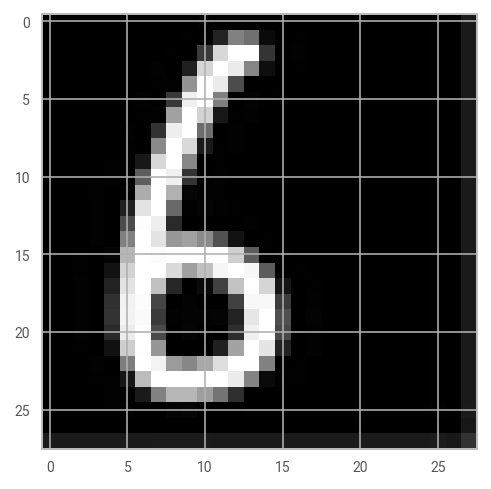

In [11]:
plt.imshow(im_tensor_shaped[0].numpy().squeeze(),cmap='gray')